# SCF-Hartree-Fock 

In [75]:
import numpy as np      
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy.integrate import quad,dblquad

## 1. create basis_fun, basis_fun2 and wave_fun
**basis_fun(x,n)**: create the basis function $\chi$
\begin{align}
    \chi_\nu = (\frac{2\zeta_\nu}{\pi})^{1/4}e^{-\zeta_\nu}x^2\\
\zeta_\nu=\frac{2}{2\nu-1}
\end{align}
where nu is a index in 1<$\nu$<k. In the program:<br>
- n:$\nu$ 
**basis_fun2(x,a,b)**: a function to calculate square of basis function:$(\frac{2\zeta_\mu}{\pi})^{1/4}e^{-\zeta_\mu}x^2*(\frac{2\zeta_\nu}{\pi})^{1/4}e^{-\zeta_\nu}x^2$<br>
- a:$\mu$
- b:$\nu$
**wave_fun*(x,c)**: calculate the ground state wave function.
\begin{equation}
    \psi=\sum^K_{\nu=1}c_\nu\chi_\nu
\end{equation}
- c: a list of coefficients($c_\nu$)

In [76]:
def basis_fun(x,n):
    zeta = 2.0/(2.0*n-1)
    #x = x.reshape((len(x),1))
    #zeta = zeta.reshape((1,len(zeta)))
    chi = np.power((2.0*zeta/np.pi),(1.0/4))*np.exp(-zeta*np.power(x,2))
    return np.round(chi,6)


def basis_fun2(x,a,b):
    return np.round(basis_fun(x,a)*basis_fun(x,b),6)

def wave_fun(x,c):
    """
    return: the total wave function 
    """
    tot_basiswave=0
    
    for i in range(0,len(c)):
        tot_basiswave +=c[i]*basis_fun(x,i+1) #rows are mu/nu columns are x_value
    #print(tot_basiswave)
    return tot_basiswave #every element in wave function: tot_basiswave, 

def normalizationF(c):
    """
    normalization factor
    """
    def wave_fun2(x,c):
        return wave_fun(x,c)*wave_fun(x,c)
    return 1.0/np.sqrt(quad(wave_fun2,-np.inf,np.inf,args=((c,)),epsrel=1e-4)[0])

def norm_wave_fun(x,c):
    return wave_fun(x,c)*normalizationF2(c)

## 2. calculate S,F,h matrix
**S(n)** is the overlap matrix, and the matrix elements can be written as:
\begin{equation}
<\chi_\mu|\chi_\nu>=\int dx_1\chi_\mu(1)\chi_\nu(1)
\end{equation}
- n: the number of terms in the ground state wave function (equal to K). 
**J(a,b,c,q=1)** is the columb matrix, and the matrix elements are:
\begin{align}
<\chi_\mu(1)|\hat{J}_0(1)|\chi_\nu(1)>=
\int\int dx_1dx_2 \chi_\mu(1)\chi_\nu(1)|\psi_0(2)|^2\frac{q^2}{|x_1-x_2|+\epsilon}
\end{align}
where,
- a,b indecates $\mu$ and $\nu$
- c contains coefficents $c_\nu$
**h(a,b)** is the matrix element for kinetic and HO potential energy:
\begin{equation}
<\chi_\mu|K+V|\chi_\nu>=\int dx_1\chi_\mu(1)(-\frac{1}{2}\nabla^2+\frac{1}{2}x_1^2)\chi_\nu(1)
\end{equation}
where,
- a,b indecates $\mu$ and $\nu$
- n: the number of terms in the ground state wave function (equal to K).
**F(a,b)** is Fock matrix.
\begin{equation}
F_{\mu\nu}=<\chi_\mu(1)|\hat{F}(1)|\chi_\nu(1)>=<\chi_\mu(1)|\hat{h}(1)|\chi_\nu(1)>+<\chi_\mu(1)|\hat{J}_0(1)|\chi_\nu(1)>
\end{equation}
- a,b indecates $\mu$ and $\nu$
**E(n,c,q=1)** is the energy corresponding to the $\psi$.
\begin{equation}
E = c^\dagger F c+c^\dagger h c
\end{equation}
- n: the number of terms in the ground state wave function (equal to K). 
- c contains coefficents $c_\nu$

In [77]:
def S(n):
    #fun:basis_fun2
    S_matrix = np.zeros((n,n))
    for i in range(0,n):
        for j in range(0,n):
            Sint=quad(basis_fun2,-10,10,args=(i+1,j+1),epsrel=1e-4)
            S_matrix[i][j] = Sint[0]
    return S_matrix

def J(a,b,c,normalfactor,q=1):  ##normalization part
    def interaction(x1,x2,q,epsilon=0.1):
        V=np.power(q,2)/(abs(x1-x2)+epsilon)
        return V
    def J_int_part(x1,x2,a,b,c,normalfactor,q):
        return basis_fun2(x1,a,b)*np.power(np.abs(wave_fun(x2,c)*normalfactor),2)*interaction(x1,x2,q)
    J_value = dblquad(J_int_part,-np.inf,np.inf,lambda x: -np.inf, lambda x: np.inf,args=(a,b,c,normalfactor,q),epsrel=1e-4)
   #print(f"J matrix error:{J_value[1]}")
    return J_value[0]

def h(n):
    def potential(x):
        return (1.0/2)*np.power(x,2)
    def Kphi(x,n):
        def dbf(x,n):
            zeta = 2.0/(2.0*n-1)
            dchi = (-2.0*zeta+4*zeta**2*x**2)*(2*zeta/np.pi)**(1.0/4)*np.exp(-zeta*np.power(x,2))
            return dchi
        return -(1.0/2)*dbf(x,n)                       #derivative(fun,x1,dx=1e-4,n=2,args=(n,))
    def h_int_part(x1,a,b):
        return  basis_fun(x1,a)*(Kphi(x1,b)+potential(x1)*basis_fun(x1,b))  ##2.0
    h_value = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            h_value[i][j]=quad(h_int_part,-np.inf,np.inf,args=((i+1,j+1)),epsrel=1e-4)[0]
    return h_value

def F(n,c,h_matrix,normalfactor,q=1):
    print("    begin calculate F...")
    Fmatrix = np.zeros((n,n)) 
    J_value = np.zeros((n,n)) 
    h_value = h_matrix 
    print("        begin calculate J...")
    for i in range(n):
        for j in range(n):
            J_value[i][j] = J(i+1,j+1,c,normalfactor,q)
            Fmatrix[i][j]=J_value[i][j]+h_value[i][j]
            print(f"J{i+1}{j+1}={J_value[i][j]:.5f}")
    print(f"J={J_value}")
    print(f"Fmatrix=\n{Fmatrix}")
    return Fmatrix,h_value

def E(n,c,h_matrix,normalfactor,q=1):
    #c_new is a column vector
    #print(c,np.sqrt(normalizationF2(c)))
    print("begin calculate E")
    c = np.array(c).reshape((len(c),1))  #####fix normalization for c
    F_matrix,h_matrix = F(n,c,h_matrix,normalfactor,q) 
    c=c*normalfactor
    E = np.dot(np.dot(np.transpose(c),F_matrix),c)+np.dot(np.dot(np.transpose(c),h_matrix),c)
    return E,F_matrix,h_matrix           

## 3. impliment SCF method to calculate ground state energy and wave function
1. initilization:
- E_init=0
- c_init=[...1.0/np.sqrt(n)...]
2. calculate E outside the loop to get **E_new**
3. In the same time, we can obtain **F matrix**,**h matrix** and **J matrix**.
4. start a loop if the energy difference between two nearest iterations is large than a threshold (0.001)
5. save energy from previous iteration to E_init
6. calculate **S matrix**
7. find the minimum eigenvalue and corresponding eigenvector.
8. the eigenvector is the **c_new** for next iteration
9. calculate E using **c_new**

In [78]:
def HF(n,q=1,E_init=0):
    print("-----------Hartree Fork--------------\n")
    num=1
    c_init=n*[1.0/np.sqrt(n)]
    S1=np.round(S(n),5) #4
    h_matrix=h(n)
    print("begining........")
    print("Initializing")
    print(f"c_init={c_init}")
    print(f"S_matrix={S1}")
    print(f"h_matrix={h_matrix}")
    print(f"--------------------# {num} iteration --------------------")
    normalfactor = normalizationF(c_init)
    print(f"normalfactor={normalfactor}")
    E_new,Fmatrix,hmatrix = E(n,c_init,h_matrix,normalfactor,q)
    print(f"E={E_new[0][0]:.5f}")
    E_vector = []
    E_vector.append(E_new[0][0])
    epsilon_vector = []
    c_vector = [c_init]
    while(abs(float(E_new)-float(E_init))>1e-3):
        if(n+1>10000):
            break
        num+=1
        print(f"error: {np.round(abs(float(E_new)-float(E_init)),5)}")
        E_init = E_new
        eigmatrix = np.dot(np.linalg.inv(S1),Fmatrix)
        [value,vector]=np.linalg.eig(eigmatrix)
        minindex = np.where(value == np. amin(value))[0][0]
        epsilon = value[minindex]
        epsilon_vector.append(epsilon)
        print(f"epsilon={epsilon}")
        print(f"--------------------# {num} iteration --------------------")
        c = vector[:,minindex]
        normalfactor = normalizationF(c)
        print(f"normalfactor={normalfactor}")
        E_new,Fmatrix,hmatrix = E(n,c,h_matrix,normalfactor,q) #4
        E_vector.append(E_new[0][0])
        c_vector.append(c*normalfactor)
        print(f"E={E_new[0][0]:.5f}")
        print(f"c={c}")
        if(abs(float(E_new)-float(E_init))<=1e-3):
            print(f"error: {np.round(abs(float(E_new)-float(E_init)),5)}\n")
    return E_vector, c_vector, epsilon_vector

In [79]:
E_vector1,c_vector,epsilon_vector = HF(4,q=1)

-----------Hartree Fork--------------

begining........
Initializing
c_init=[0.5, 0.5, 0.5, 0.5]
S_matrix=[[1.      0.93061 0.86334 0.81329]
 [0.93061 1.      0.984   0.95735]
 [0.86334 0.984   1.      0.99298]
 [0.81329 0.95735 0.99298 1.     ]]
h_matrix=[[1.06250045 0.55254679 0.37771136 0.29227561]
 [0.55254656 0.52083338 0.47662253 0.44277345]
 [0.37771105 0.47662249 0.51249998 0.5275218 ]
 [0.29227559 0.44277328 0.52752171 0.5803575 ]]
--------------------# 1 iteration --------------------
normalfactor=0.5149729749565125
begin calculate E
    begin calculate F...
        begin calculate J...
J11=2.45105
J12=2.19342
J13=2.01075
J14=1.88325
J21=2.19342
J22=2.14725
J23=2.03465
J24=1.93908
J31=2.01075
J32=2.03465
J33=1.95829
J34=1.88370
J41=1.88325
J42=1.93908
J43=1.88370
J44=1.82275
J=[[2.45105368 2.19342019 2.01074861 1.88325165]
 [2.19342019 2.14725016 2.03464727 1.93908305]
 [2.01074861 2.03464727 1.9582879  1.88370382]
 [1.88325165 1.93908305 1.88370382 1.82274634]]
Fmatrix=
[[3.

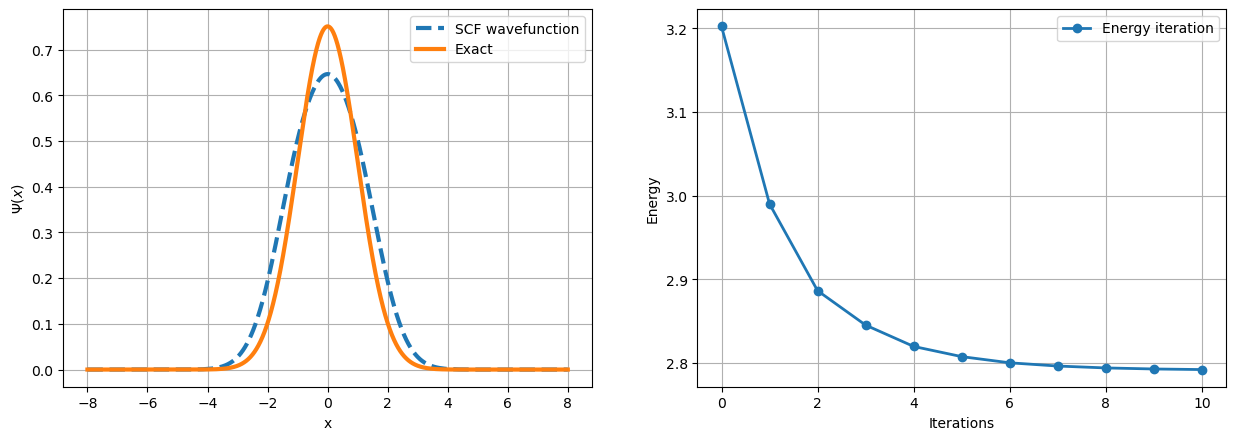

In [83]:
x = np.arange(-8,8,0.001)

def exact_HO(x):
    return (1/np.pi)**(1/4)*np.exp((-x**2)/2)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5),dpi=100)
ax1.plot(x,normalizationF(c_vector[-1])*wave_fun(x,c_vector[-1]),lw=3,label="SCF wavefunction",ls="--")
ax1.plot(x,exact_HO(x),lw=3,label="Exact")
ax1.set_xlabel("x")
ax1.set_ylabel("$\Psi(x)$")
ax2.plot(range(len(E_vector1)),E_vector1,label="Energy iteration",marker="o",lw=2)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Energy")
ax1.legend(),ax2.legend()
ax1.grid(),ax2.grid()
plt.show()

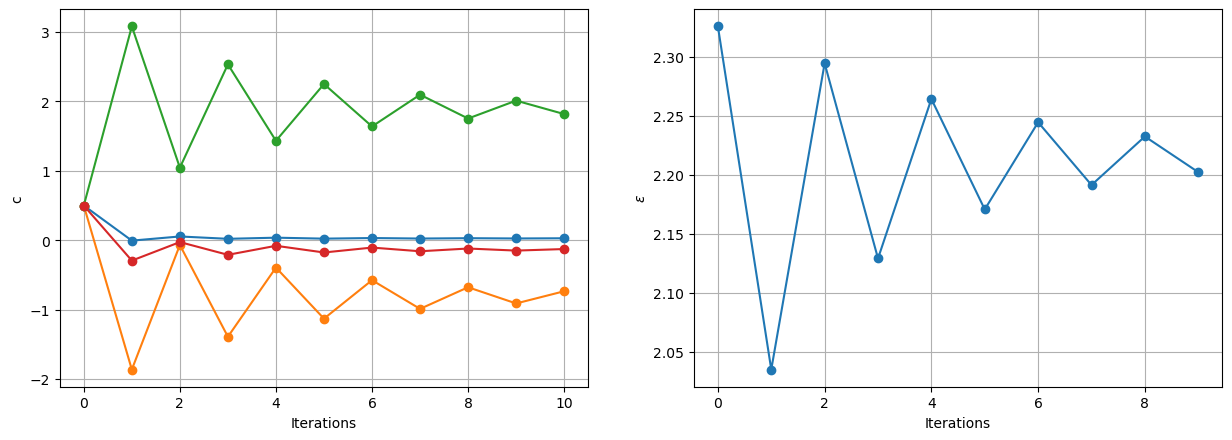

In [100]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5),dpi=100)
ax1.plot(np.arange(0,len(c_vector)),c_vector,marker="o")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("c")
ax2.plot(np.arange(0,len(epsilon_vector)),epsilon_vector,marker="o")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("$\epsilon$")
ax1.grid(),ax2.grid()
plt.show()

In [81]:
E_vector2,c_vector2,epsilon_vector2 = HF(4,q=0)

-----------Hartree Fork--------------

begining........
Initializing
c_init=[0.5, 0.5, 0.5, 0.5]
S_matrix=[[1.      0.93061 0.86334 0.81329]
 [0.93061 1.      0.984   0.95735]
 [0.86334 0.984   1.      0.99298]
 [0.81329 0.95735 0.99298 1.     ]]
h_matrix=[[1.06250045 0.55254679 0.37771136 0.29227561]
 [0.55254656 0.52083338 0.47662253 0.44277345]
 [0.37771105 0.47662249 0.51249998 0.5275218 ]
 [0.29227559 0.44277328 0.52752171 0.5803575 ]]
--------------------# 1 iteration --------------------
normalfactor=0.5149729749565125
begin calculate E
    begin calculate F...
        begin calculate J...
J11=0.00000
J12=0.00000
J13=0.00000
J14=0.00000
J21=0.00000
J22=0.00000
J23=0.00000
J24=0.00000
J31=0.00000
J32=0.00000
J33=0.00000
J34=0.00000
J41=0.00000
J42=0.00000
J43=0.00000
J44=0.00000
J=[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Fmatrix=
[[1.06250045 0.55254679 0.37771136 0.29227561]
 [0.55254656 0.52083338 0.47662253 0.44277345]
 [0.37771105 0.47662249 0.51249998 0.5

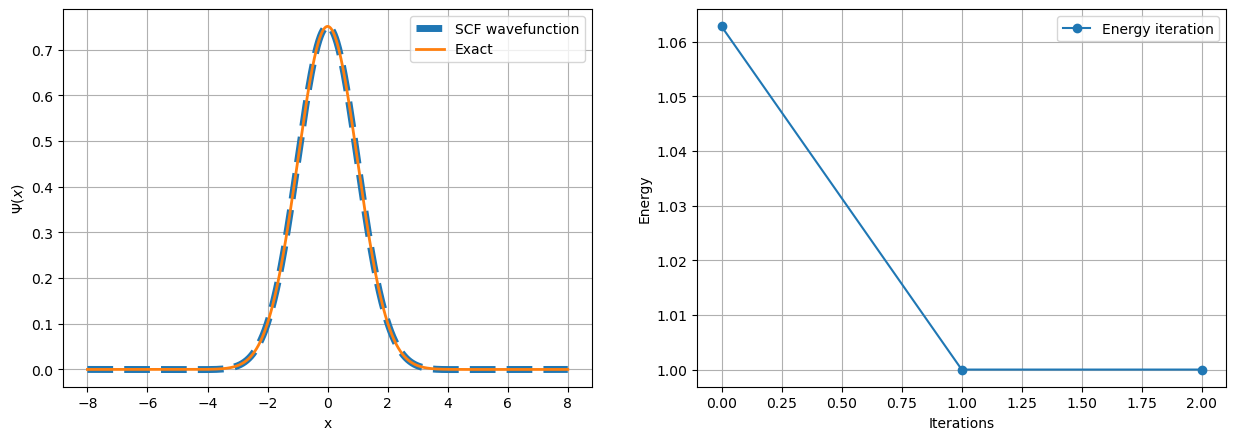

In [84]:
fig,(ax3,ax4) = plt.subplots(1,2,figsize=(15,5),dpi=100)
ax3.plot(x,normalizationF(c_vector2[-1])*wave_fun(x,c_vector2[-1]),lw=5,label="SCF wavefunction",ls="--")
ax3.plot(x,exact_HO(x),lw=2,label="Exact")
ax3.set_xlabel("x")
ax3.set_ylabel("$\Psi(x)$")
ax4.plot(np.arange(0,len(E_vector2)),E_vector2,label="Energy iteration",marker="o")
ax4.set_xlabel("Iterations")
ax4.set_ylabel("Energy")
ax3.legend(),ax4.legend()
ax3.grid(),ax4.grid()
plt.show()     

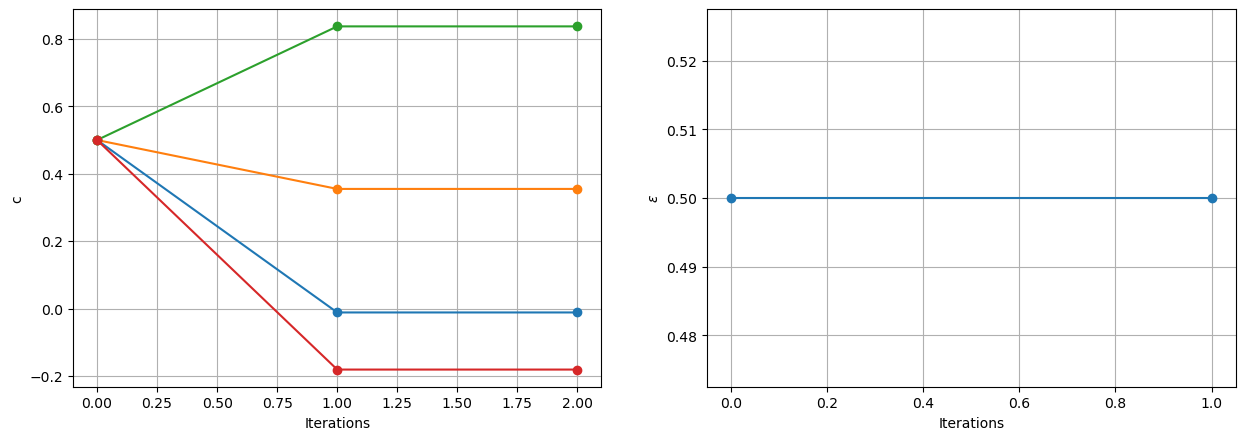

In [98]:
fig,(ax5,ax6) = plt.subplots(1,2,figsize=(15,5),dpi=100)
ax5.plot(np.arange(0,len(c_vector2)),c_vector2,marker="o")
ax5.set_xlabel("Iterations")
ax5.set_ylabel("c")
ax6.plot(np.arange(0,len(epsilon_vector2)),epsilon_vector2,marker="o")
ax6.set_xlabel("Iterations")
ax6.set_ylabel("$\epsilon$")
ax5.grid(),ax6.grid()
plt.show()